In [1]:
from simulation import Simulation
from lineages import Lineage
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
sim1 = Simulation(dt=1/120, Delta=12.5, D_sd=2, tau=25, t_sd=2) # 2fps, averge doubling time 20 mins, adder at 10

In [5]:
OD = sim1.run(length=50, vm=12.5, n=2) # initialise a long mother cell

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 123063.27it/s]


In [6]:
# sim2 = Simulation(dt=1/120, Delta=10, D_sd=2, tau=20, t_sd=3) # 2 fps
# sim2.run(length=200, vm=5) # initialise a short mother cell

In [7]:
# line = Lineage([sim1, sim2], cell=-1)
line = Lineage([sim1], cell=-1)

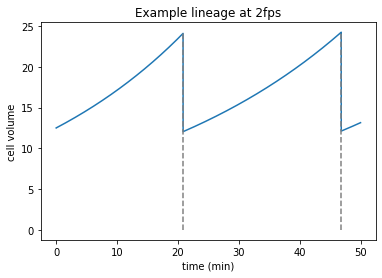

In [8]:
plt.title("Example lineage at 2fps")
plt.xlabel("time (min)")
plt.ylabel("cell volume")
line.plot()

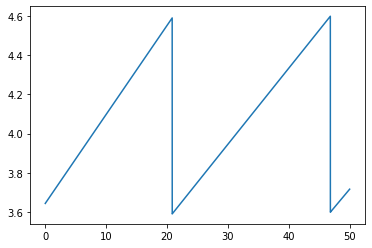

In [9]:
signal = np.array(np.log2(line.lineages[0]))
time = np.array(line.times[0])
plt.plot(time, signal)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [11:41<00:00, 19.48s/it]


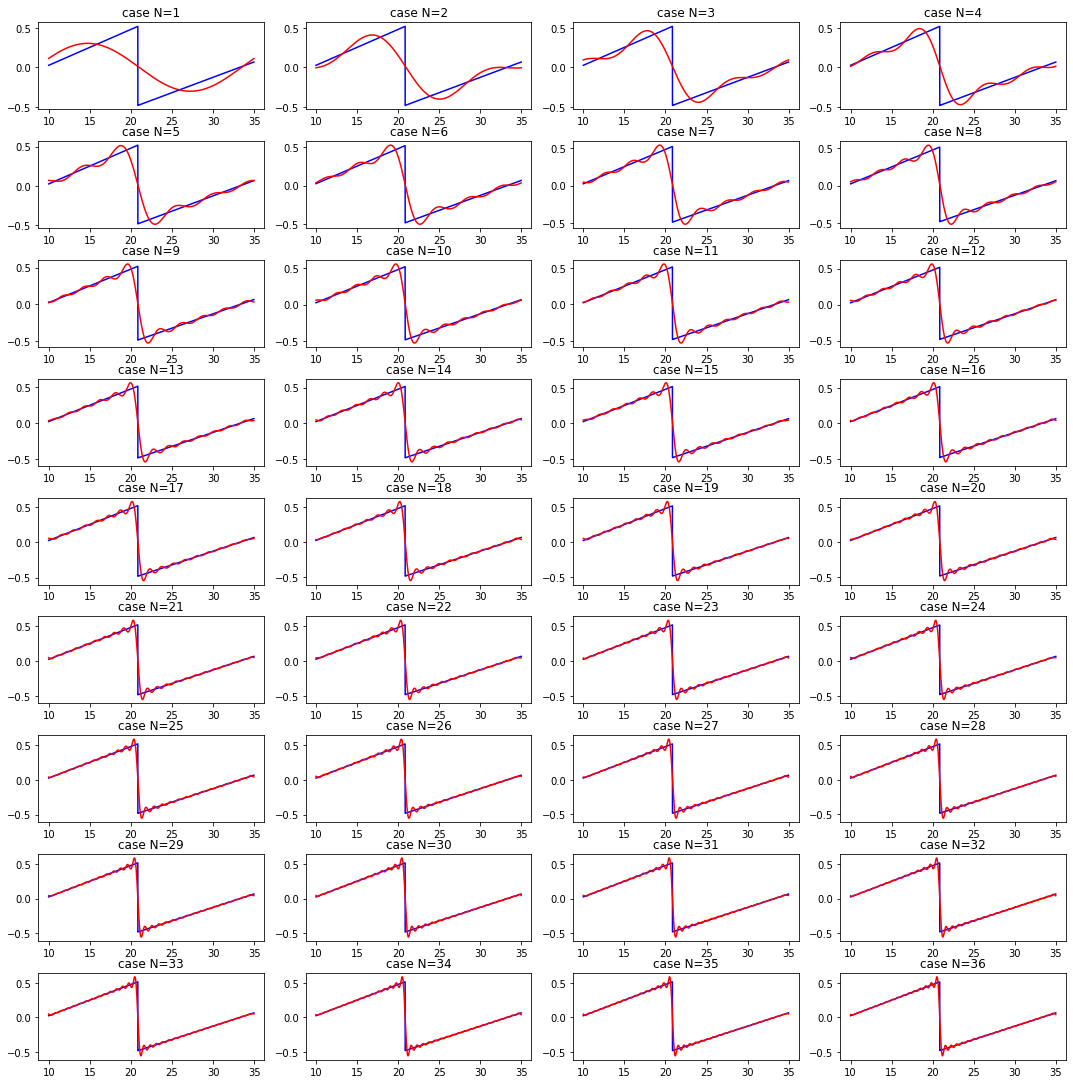

In [10]:
import numpy as np
period = 25
signal = signal[120*10:120*(10+period)]
signal = signal - np.mean(signal)
time = time[120*10:120*(10+period)]

def cn(n):
   c = signal*np.exp(-1j*2*n*np.pi*time/period)
   return c.sum()/c.size

def f(x, Nh):
   f = np.array([2*cn(i)*np.exp(1j*2*i*np.pi*x/period) for i in range(1,Nh+1)])
   return f.sum()

# y2 = np.array([f(t,50).real for t in time])

# plot(time, y)
# plot(time, y2)

maxN=36
COLs = 4 #cols of plt
ROWs = 1 + (maxN-1) // COLs #rows of plt

fig, axs = plt.subplots(ROWs, COLs, figsize=(15, 15))
fig.tight_layout()
# fig.suptitle('Cell growth in log')

errors = []
Ns = []
#plot, in the range from BT to ET, the true f(t) in blue and the approximation in red
for N in tqdm(range(1, maxN + 1)):
    Ns.append(N)
    y2 = np.array([f(t,N).real for t in time]) # 

    row = (N-1) // COLs
    col = (N-1) % COLs
    axs[row, col].set_title('case N=' + str(N))
    axs[row, col].plot(time, signal, color='blue')
    axs[row, col].plot(time, y2, color='red')
#     error = np.sum(abs(signal - y2))
    error = abs(np.argmax(y2) - np.argmax(signal))
    errors.append(error)
plt.show()

In [11]:
print(0.05*np.sum(abs(signal)))
print(errors)

36.008891698216225
[733, 481, 369, 295, 247, 212, 185, 166, 149, 136, 124, 115, 107, 99, 93, 88, 83, 79, 75, 71, 68, 65, 62, 60, 57, 55, 53, 52, 50, 48, 47, 45, 44, 43, 42, 40]


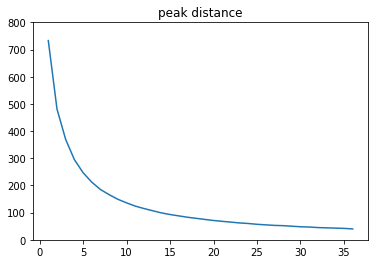

In [19]:
plt.plot(Ns, errors)
plt.ylim(0, 800)
plt.title("peak distance")
plt.show()

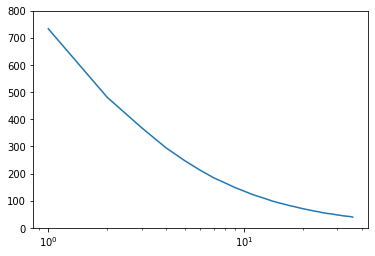

In [17]:
plt.plot(Ns, errors)
plt.ylim(0, 800)
plt.xscale('log')
plt.show()

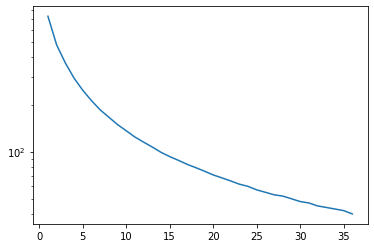

In [18]:
plt.plot(Ns, errors)
plt.yscale('log')
plt.show()

In [ ]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

#t is the independent variable
P = 25 #period value
# BT=-6. #initian value of t (begin time)
# ET=6. #final value of t (end time)
# FS=1000 #number of discrete values of t between BT and ET

#the periodic real-valued function f(t) with period equal to P
# f = lambda t: ((t % P) - (P / 2.)) ** 3

#all discrete values of t in the interval from BT and ET
# t_range = np.linspace(BT, ET, FS)
# y_true = f(t_range) #the true f(t)
y_true = signal

#function to integrate on complex field
def complex_quad(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = spi.quad(real_func, a, b, **kwargs)
    imag_integral = spi.quad(imag_func, a, b, **kwargs)
    integral = (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])
    return integral

#function that computes the complex fourier coefficients c-N,.., c0, .., cN
def compute_complex_fourier_coeffs(func, N):
    result = []
    for n in range(-N, N+1):
        cn = (1./P) * complex_quad(lambda t: func(t) * np.exp(-1j * 2 * np.pi * n * t / P), 0, P)[0]
        result.append(cn)
    return np.array(result)

#function that computes the complex form Fourier series using cn coefficients
def fit_func_by_fourier_series_with_complex_coeffs(t, C):
    result = 0. + 0.j
    L = int((len(C) - 1) / 2)
    for n in range(-L, L+1):
        c = C[n+L]
        result +=  c * np.exp(1j * 2. * np.pi * n * t / P)
    return result

maxN=10
COLs = 2 #cols of plt
ROWs = 1 + (maxN-1) // COLs #rows of plt
plt.rcParams['font.size'] = 8
fig, axs = plt.subplots(ROWs, COLs)
fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)
fig.suptitle('f(t) = ((t % P) - (P / 2.)) ** 3 where P=' + str(P))

#plot, in the range from BT to ET, the true f(t) in blue and the approximation in red
for N in range(1, maxN + 1):
    C = compute_complex_fourier_coeffs(f, N)
    #C contains the list of cn complex coefficients for n in 1..N interval.

    y_approx = fit_func_by_fourier_series_with_complex_coeffs(times, C)
    #y_approx contains the discrete values of approximation obtained by the Fourier series

    row = (N-1) // COLs
    col = (N-1) % COLs
    axs[row, col].set_title('case N=' + str(N))
    axs[row, col].scatter(t_range, y_true, color='blue', s=1, marker='.')
    axs[row, col].scatter(t_range, y_approx, color='red', s=2, marker='.')
plt.show()